In [1]:
import sys
sys.path.append("..")
import os
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
d = os.path.dirname('output_data/')
if not os.path.exists(d):
    os.makedirs(d)

In [3]:
npipes = 2           #number of pipes. only choose 1,2, or 3. Don't fuck with the relevant config files, please...
nref = 5;            #number of refinements, I'd recommend keeping this less than 6
refineT = 1
refinex = 1
if npipes ==1:
    sim = '1pipe'   #Example from Leon (2006). Exact solution known
if npipes ==2:
    sim = '2pipes'
    sim = '2pipes2'
    sim = '2pipes3'
if npipes ==3:
    sim = '3pipes1' #Example illustrating triple junction sovles. Exact solution not known

In [4]:
#read original inp and config files
ifile = sim+'.inp'
cfile = sim+'.config'
where = '../indata/'   #where original files live
where2 = '../indata/'  #where new config files live
X = []
A = []
H = []
Q = []
dVr = []
dE = []
runtime = []
Nk = []
Mk = []

In [5]:
#create nref new config files-- double number of grid points and halve the time step from previous run

for k in range(0,nref):
    count = 0;
    fr = open(where+cfile,'r')
    if (k<nref-1):
        K = pow(2,k)
    else:
        K = pow(2,k)
    newconfig = where2+sim+("%d.config"%k)
    print where+cfile
    print newconfig
    with open(newconfig, 'w') as fw:
        for line in fr:
            if '[' in line:
                fw.write(line)
                count +=1
            elif (count ==1) and (";" not in line) and len(line.split())>1:
                s = line.split()
                N = int(s[1]);
                if refinex:
                    Nnew = K*N
                else:
                    Nnew = N
                fw.write(  "%s     %i	  %s     %s\n"%(s[0],Nnew, s[2], s[3]))
            elif (count ==3) and (";" not in line) and len(line.split())>1:
                s = line.split()
                M =  int(s[1]);
                Mi = int(s[2]);
                if refineT:
                    Mnew = K*M
                else:
                    Mnew = M
                fw.write("%s        %i        %i"%(s[0],Mnew, K*Mi))
            else:
                fw.write(line)
        Nk.append(Nnew)
        Mk.append(Mnew)
        print "M is %d and N is %d"%(Mnew, Nnew)
    fr.close()
    fw.close()
mtype = 1                        #model used along network edges. 1 for Preissman Slot. 0 for uniform

../indata/2pipes3.config
../indata/2pipes30.config
M is 200 and N is 50
../indata/2pipes3.config
../indata/2pipes31.config
M is 400 and N is 100
../indata/2pipes3.config
../indata/2pipes32.config
M is 800 and N is 200
../indata/2pipes3.config
../indata/2pipes33.config
M is 1600 and N is 400
../indata/2pipes3.config
../indata/2pipes34.config
M is 3200 and N is 800
../indata/2pipes3.config
../indata/2pipes35.config
M is 6400 and N is 1600


In [6]:
for k in range(0,nref):
    fi = where+ifile
    fc = where2+sim+("%d.config"%k)
    print fi
    print fc
    n0 = PyNetwork(fi, fc, mtype)   
    V0 = n0.getTotalVolume()
    Ne = n0.Nedges
    dt = n0.T/n0.M
    n0.runForwardProblem(dt)
    Vf = n0.getTotalVolume()
    qi = [n0.q(i) for i in range(Ne)]
    h = [n0.getHofA(i) for i in range(Ne)]
    a = [qi[i][0:n0.Ns[i]] for i in range(Ne)]
    q = [qi[i][n0.Ns[i]:] for i in range(Ne)] 
    x =  [np.linspace(0,n0.Ls[i], n0.Ns[i]) for i in range(Ne)]
    dV = (Vf-V0)/V0
    print "Vf-(V0+Qin*T) = %e" %((Vf-(V0))/V0)
    E0 = n0.getKE(0)+n0.getPE(0)
    E = n0.getKE(n0.M)+n0.getPE(n0.M)
    X.append(x)
    A.append(a)
    H.append(h)
    Q.append(q)
    dx = n0.Ls[0]/n0.Ns[0]
    dE.append(dx*(E-E0))
    dVr.append(dV)
    runtime.append(n0.solve_time)
    ymax = max([max(h[i]) for i in range(Ne)])

../indata/2pipes3.inp
../indata/2pipes30.config
Vf-(V0+Qin*T) = 1.750554e-02
../indata/2pipes3.inp
../indata/2pipes31.config
Vf-(V0+Qin*T) = 1.766999e-02
../indata/2pipes3.inp
../indata/2pipes32.config
Vf-(V0+Qin*T) = 1.775221e-02
../indata/2pipes3.inp
../indata/2pipes33.config
Vf-(V0+Qin*T) = 1.779332e-02
../indata/2pipes3.inp
../indata/2pipes34.config
Vf-(V0+Qin*T) = 1.781388e-02
../indata/2pipes3.inp
../indata/2pipes35.config
Vf-(V0+Qin*T) = 1.782415e-02


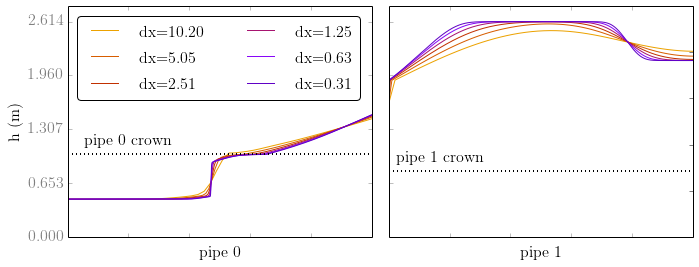

In [8]:
#plot the results 
rc('text', usetex=True)        #for tex rendering. 
rc('font', **{'family':'serif', 'serif':['Computer Modern Roman'], 
                                'monospace': ['Computer Modern Typewriter'], 'size'   : 16})
rc('font', family='serif')     #for pretty font 
import matplotlib.colors as clrs
cNorm = clrs.Normalize(vmin = 0, vmax = nref+1)
rc('font', **{'family':'serif', 'serif':['Computer Modern Roman'], 
                                'monospace': ['Computer Modern Typewriter'], 'size'   : 16})
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = 'gnuplot')
if(npipes==2):
        fig, ax = plt.subplots(figsize=(10,4),ncols= 2)
        whereleg = 'lower right'
        whereleg = 'upper left'
else:
        fig, ax  = plt.subplots(nrows=max(npipes,2))
legs = []
if npipes ==1:
        explain = ['reflection']
elif npipes==2:
        explain = ['', 'reflection']
        #explain = ['', 'outflow']
elif npipes==3:
        explain = ['to pipes 1 and 2', 'outflow', 'reflection']
for i in range(nref):
        colorVal = scalarMap.to_rgba(nref-i)
        dx = X[i][0][1]-X[i][0][0];
        if refinex:
            legs.append("dx=%2.2f"%dx)
        else:
            legs.append("dt=%.4f"%(n0.T/Mk[i]))
        for jj in range(npipes):
                j = npipes-jj-1
                ax[j].plot(X[i][j], H[i][j], color = colorVal)
                ax[j].set_ylim([0,ymax])
                ax[j].set_axis_bgcolor('white')
                ax[j].set_yticks(np.arange(0,5)/(4.)*ymax)
                #ax[j].set_ylabel('pipe %d'%j)
                ax[j].tick_params(axis='y', colors='.5')
                ax[j].tick_params(axis='x', colors='.5')
                ax[j].set_xticklabels([])
        if npipes ==1:
                Ni = len(X[i])
                htrue = np.zeros(Ni)
                for ii in range(Ni):
                        if ii/(float(Ni))<.5828:  #using R-H conditions to compute shock speed
                                htrue[ii] =  .5
                        else:
                                htrue[ii] =1.122893 
                ax[1].plot(X[i][0], H[i][0]-htrue, color = colorVal)
                ax[1].set_ylabel('error')
                ax[1].set_axis_bgcolor('black')
                ax[1].tick_params(axis='y', colors='.5')
                ax[1].tick_params(axis='x', colors='.5')
                ax[0].set_ylabel('h')
                #failed legend attempts...bloody hell, Matplotlib...
if npipes ==2:
        ymax = ceil(ymax*4)/4
        ymax = 2.8
        ax[0].legend(legs, loc =whereleg, ncol =2, fancybox=True, shadow=False)
        ax[1].set_yticklabels([])
        ax[0].plot((0, 500), (n0.Ds[0], n0.Ds[0]), 'k:', linewidth=2.0)
        ax[1].plot((0, 500), (n0.Ds[1], n0.Ds[1]), 'k:', linewidth=2.0)
        ax[0].set_ylim(0,ymax)
        ax[1].set_ylim(0,ymax)
        q0 = Q[0][0][0]
        h0 = H[0][0][0]
        ax[0].set_ylabel('h (m)')
        ax[0].set_xlabel('pipe 0')
        ax[1].set_xlabel('pipe 1')
        #explain[1] = 'pipe 0, h(x=L) = %1.1f'%(0.1)
        #ax[0].set_xlabel('x (m)')
else:                         # Put a legend below current axis
        box = ax[-1].get_position()
        ax[-1].set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
        ax[-1].legend(legs,loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)

#fig.suptitle('Water height along pipes at time t = %3.1f s'%n0.T, fontsize =10)
leg = ax[0].get_legend()
legt = leg.get_texts()
frame = leg.get_frame()
plt.setp(legt, fontsize=16, color = 'black')
plt.tight_layout()
#frame.set_facecolor('black') 
#ax[npipes-1].set_xlabel('x (m)')
ax[0].annotate(
    r"pipe 0 crown", xy=(10, 1.1), xycoords='data',
    xytext=(10, 1.1), textcoords='offset points',size=16)
ax[1].annotate(
    r"pipe 1 crown", xy=(10, 0.9), xycoords='data',
    xytext=(1, 0.9), textcoords='offset points',size=16)
for j in range(1,npipes):
        ax2 = ax[j].twinx()
        ax2.set_yticklabels([])
        ax2.set_xticklabels([])
        #ax2.set_ylabel("h (m)")
        #ax2.tick_params(axis='y', colors='black')
savefig("../conv2reallynewer.eps", format='eps')

-0.175308803825
1.65586307156
1.48055426773


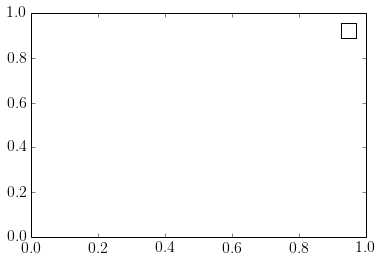

In [9]:
htrue = H[-1]
einf = np.zeros((nref-1,Ne))
eL2 = np.zeros((nref-1,Ne))
eL1 = np.zeros((nref-1,Ne))
for k in range(nref-1):
    for i in range(npipes):
        if refinex:
            stride = pow(2,nref-k-1)
            #hcomp = [(1./stride)*sum(htrue[i][j*stride:stride*(j+1)]) for j in range(Nk[k])]#average all cells, don't just take one!
            hcomp = htrue[i][0::stride]
        else: 
            hcomp = htrue[i]
        #print i
        #print hcomp-H[k][i]
        ht = np.array(H[k][i])
        hc = np.array(hcomp)
        #plot(linspace(i*500,(i+1)*500, Nk[k]), hcomp,'.')
        einf[k][i] = max((abs(hcomp-H[k][i])))
        dx =n0.Ls[i]/Nk[k]
        #print dx
        einf[k][i] = max((abs(hc-ht)))
        eL2[k][i] = sum((hc-ht)**2)*dx
        eL1[k][i] = sum(abs(hc-ht))*dx
        #einf[k][i] = max((abs(hcomp-H[k][i])))
        #eL2[k][i] = sum([(hcomp[j]-H[k][i][j])**2 for j in range(len(hcomp))])*n0.Ls[i]/Nk[i]
        #eL1[k][i] = sum([abs(hcomp[j]-H[k][i][j]) for j in range(len(hcomp))])*n0.Ls[i]/Nk[i]
        #plot(linspace(i*500,500+i*500,Nk[k]),H[k][i])
legend(['%d'%i for i in range(nref-1)])
Einf = [max(einf[k][:]) for k in range(nref-1)]
EL2 = [sqrt(sum(eL2[k][:])) for k in range(nref-1)]
EL1 = [sum(eL1[k][:]) for k in range(nref-1)]
#print einf
#print eL2
#print eL1
#plot(linspace(0,500, Nk[-1]), htrue[0])
#plot(linspace(500,1000, Nk[-1]), htrue[1])
#plot(linspace(0,500, Nk[-3]), H[-3][0])
#print 1./stride*sum(htrue[0][0:stride])
#print stride
#sum(htrue[0][0:0+stride])/stride

#print hcomp[0:10]
#print H[k][1][0:10]
dh =  htrue[0][-1]-htrue[1][0]
print dh
#print htrue[2][0]
print htrue[1][0]
print htrue[0][-1]

In [10]:
#tabulate results in LaTex friendly manner
L = n0.Ls[0]
print " $N$   & $M$ &  run time (s)&  $||e||_1$  \\\\"
for k in range(nref-1):
    #print "%3d & %4d & %2.2f   &        %1.3e &   %1.3e  &  %1.3e  &  %1.3e\\\\"%(Nk[k], Mk[k], runtime[k], dVr[k],dE[k], EL2[k]/L, EL1[k]/L)     
    #print "%3d & %4d & %2.2f   &        %1.5f &   %1.3e &%1.3e \\\\"%(Nk[k], Mk[k], runtime[k],EL1[k]/L, dVr[k]/Mk[k], dE[k]-dE[-1] )  
    print "%3d & %4d & %2.2f   &        %1.5f &    \\\\"%(Nk[k], Mk[k], runtime[k],EL1[k]/L)     

 $N$   & $M$ &  run time (s)&  $||e||_1$  \\
 50 &  200 & 0.14   &        0.19573 &    \\
100 &  400 & 0.54   &        0.12175 &    \\
200 &  800 & 2.12   &        0.06986 &    \\
400 & 1600 & 8.41   &        0.03569 &    \\
800 & 3200 & 33.42   &        0.01380 &    \\


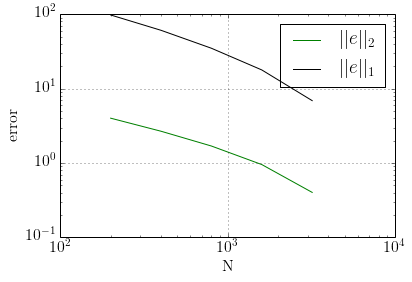

In [27]:
#make error plots
fig2= plt.figure()
ax2= fig2.add_subplot(111)
ax2.set_yscale('log')
ax2.set_xscale('log')
if refineT:
    #ax2.plot(Mk[0:nref-1], Einf)
    ax2.plot(Mk[0:nref-1], EL2,'g')
    ax2.plot(Mk[0:nref-1], EL1,'k')
    #ax2.plot(Mk[0:2], [pow(Mk[0],-1), pow(Mk[1], -1)],'r')
else:    
    #ax2.plot(Nk[0:nref-1], Einf)
    ax2.plot(Nk[0:nref-1], EL2,'g')
    ax2.plot(Nk[0:nref-1], EL1,'k')
    ax2.plot(Nk[0:2], [pow(Nk[0],-1)+1, pow(Nk[1], -1)+1],'r')
ax2.grid(True)
ax2.set_xlabel('N')
ax2.set_ylabel('error')
ax2.legend([r'$||e||_2$',r'$||e||_1$'])

In [28]:
for k in range(len(Einf)-1):
    print "%f   %f   %f"  %((dVr[k]-dVr[-1])/(dVr[k+1]-dVr[-1]), EL2[k]/EL2[k+1], EL1[k]/EL1[k+1])

2.066667   1.498418   1.607667
2.142857   1.580470   1.742745
2.333333   1.775055   1.957117
3.000000   2.366976   2.586445


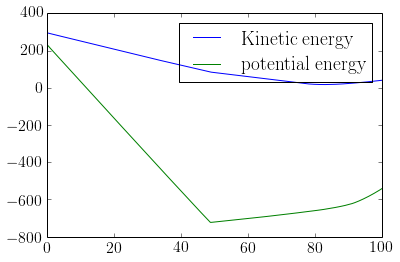

In [33]:
Ke = np.array([n0.getKE(i) for i in range(n0.M)])
Pe = np.array([n0.getPE(i) for i in range (n0.M)])
t= linspace(0,n0.T,n0.M)
u0 = 1./0.6735743589
E0 = (Ke[0]+Pe[0])
plot(t,Ke,t,Pe)
legend(['Kinetic energy', 'potential energy'])